[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_tensorflow/blob/master/examples/notebooks/Colab_OpenVINO_TensorFlow_object_detection_example.ipynb)



# **Object Detection with OpenVINO™ integration with TensorFlow**:

OpenVINO™ integration with TensorFlow is designed for TensorFlow developers who want to get started with OpenVINO™ in their inferencing applications. This product effectively delivers OpenVINO™ inline optimizations which enhance inferencing performance with minimal code modifications. OpenVINO™ integration with TensorFlow accelerates inference across many AI models on a variety of Intel® silicon such as: 
*   Intel® CPUs
*   Intel® integrated GPUs
*   Intel® Movidius™ Vision Processing Units - referred to as VPU
*   Intel® Vision Accelerator Design with 8 Intel Movidius™ MyriadX VPUs - referred to as VAD-M or HDDL

**Overview**

The following code demonstrates acceleration of YOLOv4 using OpenVINO™ integration with TensorFlow. We compare the performance of YOLOv4 with and without OpenVINO™ integration with TensorFlow. This model is a real time object detection algorithm that identifies objects in images & videos. It detects these objects by using features learned by a deep convolutional neural network.

## Install OpenVINO™ integration with TensorFlow

In [1]:
# Upload the required wheel files, models and images in a google drive folder
# Uncomment and run the below command to copy them in your current workspace
#!cp /content/drive/MyDrive/TF-OV/working_dir_files/* . 

import os
import time

# Enable these variables for runtime inference optimizations
os.environ["OPENVINO_TF_CONVERT_VARIABLES_TO_CONSTANTS"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"

!python3 -m pip -q install --upgrade pip
!python3 -m pip -q install pillow
!python3 -m pip -q install keras_applications
!python3 -m pip -q install wordcloud

# Install TensorFlow (v2.8.0) and OpenVINO-TensorFlow (v2.0.0) only if they aren't found
!if python3 -c "import tensorflow"; then echo "Found TensorFlow. Skipping."; else echo "TensorFlow Not Found. Installing."; python3 -m pip -q install tensorflow==2.8.0; fi
!if python3 -c "import openvino_tensorflow"; then echo "Found OpenVINO-TensorFlow. Skipping."; else echo "OpenVINO-TensorFlow Not Found. Installing."; python3 -m pip -q install openvino-tensorflow==2.0.0; fi

2022-04-28 13:49:24.852134: I tensorflow/core/util/util.cc:159] Experimental oneDNN custom operations are on. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Found TensorFlow. Skipping.
2022-04-28 13:49:27.074577: I tensorflow/core/util/util.cc:159] Experimental oneDNN custom operations are on. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Found OpenVINO-TensorFlow. Skipping.


Change ```OVTF_DIR``` value to directory where you have cloned openvino_tensorflow directory

Ex. if you have /home/\<username\>/openvino_tensorflow then OVTF_DIR value will be /home/\<username\>/

In [2]:
OVTF_DIR = "/"
RAW_GITHUB_COMMON = "https://raw.githubusercontent.com/openvinotoolkit/openvino_tensorflow/master/examples/common/"
GITHUB_EXAMPLES = "https://github.com/openvinotoolkit/openvino_tensorflow/raw/master/examples/data/"
RAW_GITHUB_EXAMPLES = "https://raw.githubusercontent.com/openvinotoolkit/openvino_tensorflow/master/examples/"

In [3]:
import os

files = os.listdir('.')
if ('common' not in files or 'examples' not in files) and 'openvino_tensorflow' not in os.listdir(OVTF_DIR):
    !mkdir ./common
    !wget {RAW_GITHUB_COMMON}/post_process.py -O ./common/post_process.py
    !wget {RAW_GITHUB_COMMON}/pre_process.py -O ./common/pre_process.py
    !wget {RAW_GITHUB_COMMON}/utils.py -O ./common/utils.py
    !mkdir -p ./examples/data
    !wget {GITHUB_EXAMPLES}/grace_hopper.jpg -O ./examples/data/grace_hopper.jpg
    !wget {GITHUB_EXAMPLES}/yolov4_anchors.txt -O ./examples/data/yolov4_anchors.txt
    !wget {RAW_GITHUB_EXAMPLES}/convert_yolov4.sh -O ./examples/convert_yolov4.sh
    !wget {RAW_GITHUB_EXAMPLES}/keras_to_tensorflow.patch -O ./examples/keras_to_tensorflow.patch

### This additional check is to facilitate 'common' import. Helpful in a docker container.

In [4]:
import sys

if 'openvino_tensorflow' in os.listdir(OVTF_DIR):
    sys_append = os.path.abspath(OVTF_DIR + "/openvino_tensorflow/examples/")
    sys.path.append(sys_append)

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import openvino_tensorflow as ovtf

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import wordcloud
from wordcloud import WordCloud, STOPWORDS

from PIL import Image
from common.utils import get_input_mode, get_colors, draw_boxes, get_anchors, rename_file
from common.pre_process import preprocess_image_yolov3 as preprocess_image
from common.post_process import yolo3_postprocess_np

2022-04-28 13:49:29.209165: I tensorflow/core/util/util.cc:159] Experimental oneDNN custom operations are on. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Let's get the model





In [6]:
# Download and Convert the YoloV4 model
files = os.listdir('.')
if 'examples' in files:
    path = "examples"
else:
    path = "{0}/openvino_tensorflow/examples/".format(OVTF_DIR)
%cd {path}
!chmod +x convert_yolov4.sh && bash convert_yolov4.sh
# Once the model conversion is completed; move back to outside of examples directory
%cd ../

/home/openvino/openvino_tensorflow/examples/notebooks/examples
mkdir: cannot create directory ‘temp_build’: File exists
  Using cached tensorflow-2.5.1-cp38-cp38-manylinux2010_x86_64.whl (454.5 MB)
  Using cached opencv_python-4.2.0.32-cp38-cp38-manylinux1_x86_64.whl (28.2 MB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.19.5-cp38-cp38-manylinux2010_x86_64.whl (14.9 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached protobuf-3.20.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Preparing metadata (setup.py) ... done
  Using cached absl_py-0.1

In [32]:
def load_coco_names(file_name):
    """Parses the label file with only class names,
      and returns a dictionary mapping the class IDs to class names.
    """
    names = {}
    with open(file_name) as f:
        for id_, name in enumerate(f):
            names[id_] = name
    return names

In [33]:
def load_labels(label_file):
    """Parses the label file, assuming that labels are separated with a newline
       in the file and returns the list of labels.
    """  
    label = []
    proto_as_ascii_lines = tf.io.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

In [34]:
def model_predit(model, source, classes, labels, colors, anchors, file_rename = False):
    image = Image.open(source)
    img = np.asarray(image)
    image_width, image_height = image.size
    img_resized = tf.convert_to_tensor(preprocess_image(image, (input_height, input_width)))

    # Warmup
    detected_boxes = model(img_resized)
    # Run
    start = time.time()
    global elapsed_time
    detected_boxes = model(img_resized)
    elapsed_time = time.time() - start
    print('Inference time in ms: %f' % (elapsed_time * 1000))
    
    image_shape = tuple((image_height, image_width))  
    # apply non max suppresion, draw boxes and save updated image
    out_boxes, out_classes, out_scores = yolo3_postprocess_np(
            detected_boxes,
            image_shape,
            anchors,
            len(labels), (input_height, input_width),
            max_boxes=10,
            confidence=conf_threshold,
            iou_threshold=iou_threshold,
            elim_grid_sense=True)
    
    # used for word cloud
    global label_classes
    label_classes.extend([labels[cls] for cls in out_classes])
    
    # rename input image file
    if file_rename:
        rename_file(source, out_classes, labels)
        return
        
    img_bbox = draw_boxes(img, out_boxes, out_classes, out_scores,
                        labels, colors)
    if output_dir:
        cv2.imwrite(os.path.join(output_dir, "detections.jpg"), img_bbox)
    else:
        cv2.imwrite("detections.jpg", img_bbox)
    return img

In [35]:
def infer_openvino_tensorflow(image_file, rename_required = False):
    """Takes the tensorflow model and all other input parameters as arguments. 
       Runs inference with the object detection model and prints the predictions.
    """

    # Load model and process input image
    print("CREATE MODEL - BEGIN")
    print("Model Loading...")
    model = tf.saved_model.load(model_file)
    print("CREATE MODEL - END")

    global label_classes
    label_classes = []

    if label_file:
        classes = load_coco_names(label_file)
        labels = load_labels(label_file)
        colors = get_colors(labels)

    if anchor_file:
        anchors = get_anchors(anchor_file)

    #Preprocess Image
    if '.' in image_file:
        print("PREDICTION - BEGIN")
        img = model_predit(model, image_file, classes, labels, colors, anchors, rename_required)
        plt.imshow(img)
        print("PREDICTION - END")
    else:
        count = 0
        start_time = time.time()
        print("PREDICTION - BEGIN")
        nb_of_files = len([name for name in os.listdir(image_file) if os.path.isfile(os.path.join(image_file, name))])
        print(f'Found {nb_of_files} files in {image_file} directory. Starting Inference.')
        if rename_required:
            print('rename_required flag is found as True, detected objects will be appended in file name.')
        for filename in os.listdir(image_file):
            input_file = os.path.join(image_file, filename)
            if os.path.isfile(input_file):
                count += 1
                print(f'\nProcessing file {count}: {input_file}')
                model_predit(model, input_file, classes, labels, colors, anchors, rename_required)
        print("PREDICTION - END\n")
        global elapsed_time
        elapsed_time = time.time() - start_time
        print(f'Inference successfully completed in {elapsed_time} ms on {nb_of_files} images located at {image_file}')

# Now let's infer

*   Set all the parameters needed for inference
*   Enable OpenVINO™ integration with TensorFlow, and set Backend in just a few simple lines of code to boost performace
*   Infer the input image 
*   Output the predicted bounding box on the image, and the inference time with OpenVINO™ integration with TensorFlow enabled

#### Set Parameters

In [36]:
model_file = "examples/data/yolo_v4"
label_file = "examples/data/coco.names"
anchor_file = "examples/data/yolov4_anchors.txt"
input_height = 416
input_width = 416
backend_name = "CPU"
output_dir = "."
conf_threshold = 0.6
iou_threshold = 0.5
label_classes = []
elapsed_time = None

# Print list of available backends
print('Available Backends:', ovtf.list_backends())
ovtf.set_backend(backend_name)
print("OpenVINO TensorFlow is enabled")

Available Backends: ['CPU']
OpenVINO TensorFlow is enabled


## Case 1a: Inference Run with OVTF on Single Image

CREATE MODEL - BEGIN
Model Loading...
CREATE MODEL - END
PREDICTION - BEGIN


2022-04-28 15:32:26.427196: I /opt/intel/openvino_tensorflow/openvino_tensorflow/rewrite_pass.cc:124] openvino-tensorflow is available but disabled.


Inference time in ms: 673.377037
elephant 0.91
person 0.76
PREDICTION - END


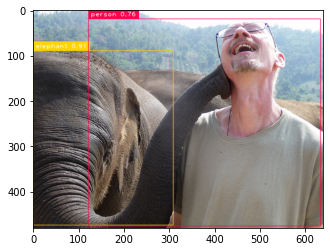

In [37]:
input_file = "examples/mock_test_25/000000006894.jpg"
infer_openvino_tensorflow(input_file)
single_img_with_ovtf_elapsed_time = elapsed_time

## Case 1b: Inference Run without OVTF on Single Image

*   Disable OpenVINO™ integration with TensorFlow to gauge the achieved performance boost
*   Infer the input image again
*   Output the predicted bounding box on the image, and the inference time with OpenVINO™ integration with TensorFlow disabled

OpenVINO TensorFlow is disabled
CREATE MODEL - BEGIN
Model Loading...
CREATE MODEL - END
PREDICTION - BEGIN


2022-04-28 15:32:43.388624: I /opt/intel/openvino_tensorflow/openvino_tensorflow/rewrite_pass.cc:124] openvino-tensorflow is available but disabled.


Inference time in ms: 680.741310
elephant 0.91
person 0.76
PREDICTION - END


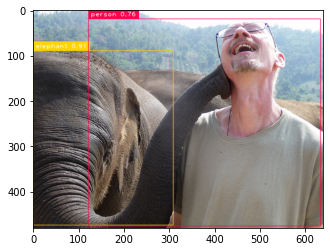

In [38]:
ovtf.disable() ## Disabling OVTF
print("OpenVINO TensorFlow is disabled")
infer_openvino_tensorflow(input_file)
single_img_without_ovtf_elapsed_time = elapsed_time

## Case 2a: Inference Run using OVTF on sample 25 images in a directory

In [39]:
ovtf.enable() ## Enabling OVTF
directory = 'examples/mock_test_25/'
infer_openvino_tensorflow(image_file=directory)
multi_img_with_ovtf_elapsed_time = elapsed_time

CREATE MODEL - BEGIN
Model Loading...
CREATE MODEL - END
PREDICTION - BEGIN
Found 26 files in examples/mock_test_25/ directory. Starting Inference.

Processing file 1: examples/mock_test_25/000000009400.jpg
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    924978] [python3] usb_find_device_with_bcd:266	Library has not been initialized when loaded
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    925039] [python3] usb_find_device_with_bcd:266	Library has not been initialized when loaded
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    925076] [python3] usb_find_device_with_bcd:266	Library has not been initialized when loaded
[E:] [BSL] found 0 ioexpander device
E: [xLinkUsb] [    925105] [python3] usb_find_device_with_bcd:266	Library has not been initialized when loaded
2022-04-28 15:33:00.300222: OVTF Summary -> 382 out of 1470 nodes in the graph (25%) are now running with OpenVINO™ backend
Inference time in ms: 321.369171
laptop 0.98
person 0.98
person 0.97
cup 0.97

## Case 2b: Inference Run without OVTF on sample 25 images in a directory

In [40]:
ovtf.disable() ## Disabling OVTF
infer_openvino_tensorflow(image_file=directory)
multi_img_without_ovtf_elapsed_time = elapsed_time

CREATE MODEL - BEGIN
Model Loading...
CREATE MODEL - END
PREDICTION - BEGIN
Found 26 files in examples/mock_test_25/ directory. Starting Inference.

Processing file 1: examples/mock_test_25/000000009400.jpg


2022-04-28 15:33:49.256256: I /opt/intel/openvino_tensorflow/openvino_tensorflow/rewrite_pass.cc:124] openvino-tensorflow is available but disabled.


Inference time in ms: 855.368137
laptop 0.98
person 0.98
person 0.97
cup 0.97
person 0.96
laptop 0.96
laptop 0.95
person 0.94
cup 0.91
person 0.88

Processing file 2: examples/mock_test_25/000000006894.jpg
Inference time in ms: 897.324324
elephant 0.91
person 0.76

Processing file 3: examples/mock_test_25/000000001584.jpg
Inference time in ms: 972.556353
bus 1.00
bus 0.97
bus 0.95
person 0.91
person 0.83
person 0.80
person 0.63

Processing file 4: examples/mock_test_25/000000001268.jpg
Inference time in ms: 799.567699
person 0.99
person 0.98
handbag 0.98
person 0.97
person 0.94

Processing file 5: examples/mock_test_25/000000000724.jpg
Inference time in ms: 853.416681
stop sign 1.00

Processing file 6: examples/mock_test_25/000000012120.jpg
Inference time in ms: 890.166521
person 0.99
person 0.99
person 0.97
person 0.87
tennis racket 0.70

Processing file 7: examples/mock_test_25/000000006040.jpg
Inference time in ms: 806.994438
train 0.98
car 0.69

Processing file 8: examples/mock_tes

## Build NLP-based Word Cloud with Inference Run using OVTF

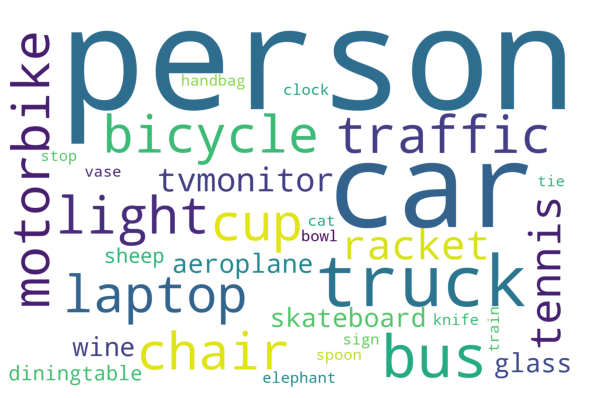

In [41]:
## Build NLP-based Word Cloud with Inference Run using OVTF

comment_words = ''
stopwords = set(STOPWORDS)
for val in label_classes:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 1500, height = 1000, background_color ='white',
                      stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Case 3a: Inference Run using OVTF on all 100 images in the directory

In [42]:
ovtf.enable() ## Enabling OVTF
directory = 'examples/mock_test_100/'
infer_openvino_tensorflow(image_file=directory)
multi_imges_with_ovtf_elapsed_time = elapsed_time

CREATE MODEL - BEGIN
Model Loading...
CREATE MODEL - END
PREDICTION - BEGIN
Found 100 files in examples/mock_test_100/ directory. Starting Inference.

Processing file 1: examples/mock_test_100/000000000785.jpg
2022-04-28 15:34:54.274639: OVTF Summary -> 382 out of 1470 nodes in the graph (25%) are now running with OpenVINO™ backend
Inference time in ms: 559.854031
person 1.00

Processing file 2: examples/mock_test_100/000000008021.jpg
Inference time in ms: 666.822672
person 0.99
tie 0.98
person 0.96
person 0.72

Processing file 3: examples/mock_test_100/000000009400.jpg
Inference time in ms: 501.842976
laptop 0.98
person 0.98
person 0.97
cup 0.97
person 0.96
laptop 0.96
laptop 0.95
person 0.94
cup 0.91
person 0.88

Processing file 4: examples/mock_test_100/000000006894.jpg
Inference time in ms: 491.750002
elephant 0.91
person 0.76

Processing file 5: examples/mock_test_100/000000005586.jpg
Inference time in ms: 580.698490
person 0.97
person 0.95
tennis racket 0.78
person 0.76
person 0.

## Case 3b: Inference Run without OVTF on all 100 images in the directory

In [43]:
ovtf.disable() ## Disabling OVTF
infer_openvino_tensorflow(image_file=directory)
multi_imges_without_ovtf_elapsed_time = elapsed_time

CREATE MODEL - BEGIN
Model Loading...
CREATE MODEL - END
PREDICTION - BEGIN
Found 100 files in examples/mock_test_100/ directory. Starting Inference.

Processing file 1: examples/mock_test_100/000000000785.jpg


2022-04-28 15:37:07.918455: I /opt/intel/openvino_tensorflow/openvino_tensorflow/rewrite_pass.cc:124] openvino-tensorflow is available but disabled.


Inference time in ms: 1125.913858
person 1.00

Processing file 2: examples/mock_test_100/000000008021.jpg
Inference time in ms: 907.563925
person 0.99
tie 0.98
person 0.96
person 0.72

Processing file 3: examples/mock_test_100/000000009400.jpg
Inference time in ms: 844.996214
laptop 0.98
person 0.98
person 0.97
cup 0.97
person 0.96
laptop 0.96
laptop 0.95
person 0.94
cup 0.91
person 0.88

Processing file 4: examples/mock_test_100/000000006894.jpg
Inference time in ms: 1039.489985
elephant 0.91
person 0.76

Processing file 5: examples/mock_test_100/000000005586.jpg
Inference time in ms: 866.699934
person 0.97
person 0.95
tennis racket 0.78
person 0.76
person 0.62

Processing file 6: examples/mock_test_100/000000004395.jpg
Inference time in ms: 841.156483
person 0.99
tie 0.99

Processing file 7: examples/mock_test_100/000000003156.jpg
Inference time in ms: 872.731209
person 0.99
toilet 0.85

Processing file 8: examples/mock_test_100/000000001353.jpg
Inference time in ms: 804.121733
perso

## Let's Compare Performance Boost with & without OVTF for 100 images in the directory

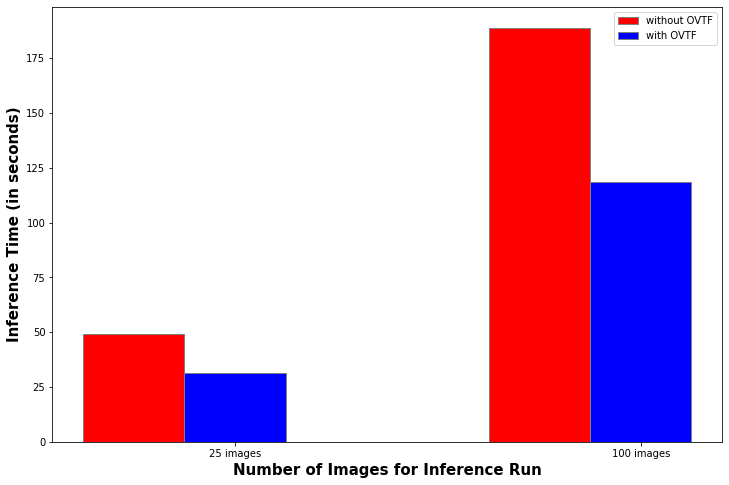

In [46]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
with_ovtf = [multi_img_with_ovtf_elapsed_time,multi_imges_with_ovtf_elapsed_time]
without_ovtf = [multi_img_without_ovtf_elapsed_time, multi_imges_without_ovtf_elapsed_time]
 
# Set position of bar on X axis
br1 = np.arange(len(with_ovtf))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, without_ovtf, color ='r', width = barWidth,
        edgecolor ='grey', label ='without OVTF')
plt.bar(br2, with_ovtf, color ='b', width = barWidth,
        edgecolor ='grey', label ='with OVTF')

# Adding Xticks
plt.xlabel('Number of Images for Inference Run', fontweight ='bold', fontsize = 15)
plt.ylabel('Inference Time (in seconds)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(with_ovtf))],
        ['25 images', '100 images'])
 
plt.legend()
plt.show()

## Rename Multiple Inputs files with Inference Run using OVTF

In [47]:
label_classes = []
directory = 'examples/mock_test_5/'
infer_openvino_tensorflow(image_file=directory, rename_required = True)

CREATE MODEL - BEGIN
Model Loading...
CREATE MODEL - END
PREDICTION - BEGIN
Found 5 files in examples/mock_test_5/ directory. Starting Inference.
rename_required flag is found as True, detected objects will be appended in file name.

Processing file 1: examples/mock_test_5/000000006894.jpg


2022-04-28 15:46:07.743813: I /opt/intel/openvino_tensorflow/openvino_tensorflow/rewrite_pass.cc:124] openvino-tensorflow is available but disabled.


Inference time in ms: 644.119501
Sorry, image has no exif data.
newfilename  examples/mock_test_5/000000006894-elephant-person-IntelOpenVINO.jpg

Processing file 2: examples/mock_test_5/000000006040.jpg
Inference time in ms: 710.416555
Sorry, image has no exif data.
newfilename  examples/mock_test_5/000000006040-train-car-IntelOpenVINO.jpg

Processing file 3: examples/mock_test_5/000000001761.jpg
Inference time in ms: 1182.305574
Sorry, image has no exif data.
newfilename  examples/mock_test_5/000000001761-2aeroplane-IntelOpenVINO.jpg

Processing file 4: examples/mock_test_5/000000000885.jpg
Inference time in ms: 736.491919
Sorry, image has no exif data.
newfilename  examples/mock_test_5/000000000885-3person-tennisracket-IntelOpenVINO.jpg

Processing file 5: examples/mock_test_5/000000008690.jpg
Inference time in ms: 749.691248
Sorry, image has no exif data.
newfilename  examples/mock_test_5/000000008690-2sheep-2person-IntelOpenVINO.jpg
PREDICTION - END

Inference successfully complete

#### Helper Method

In [48]:
# Rename the files back to original
directory = 'examples/mock_test_5/'
for filename in os.listdir(directory):
    input_file = os.path.join(directory, filename)
    if os.path.isfile(input_file):
        new_file_name = input_file.split('/')[-1].split('-')[0] + '.jpg'
        os.rename(input_file, directory + new_file_name)